# Import libraries

In [1]:
# System
import os
from os import path
import sys
import contextlib
from os import listdir
from os.path import isfile, join

# Basics
import matplotlib.pyplot as plt
import numpy as np
from numpy import convolve
import array
import pandas as pd

# Audio
import audioread
import wave
from pydub import AudioSegment
from pydub.utils import get_array_type
import requests
import ffmpeg

In [2]:
# Parameters

# Figure parameters
%matplotlib inline
fig_width = 16
fig_height = 4

# Converting mp3 to wav

In [3]:
filename = './biisivisailucovid19.mp3'

def decode(filename):
    filename = os.path.abspath(os.path.expanduser(filename))
    if not os.path.exists(filename):
        print("File not found.", file=sys.stderr)
        sys.exit(1)

    try:
        with audioread.audio_open(filename) as f:
            print('Input file: %i channels at %i Hz; %.1f seconds.' %
                  (f.channels, f.samplerate, f.duration),
                  file=sys.stderr)
            print('Backend:', str(type(f).__module__).split('.')[1],
                  file=sys.stderr)

            with contextlib.closing(wave.open(filename + '.wav', 'w')) as of:
                of.setnchannels(f.channels)
                of.setframerate(f.samplerate)
                of.setsampwidth(2)

                for buf in f:
                    of.writeframes(buf)

    except audioread.DecodeError:
        print("File could not be decoded.", file=sys.stderr)
        sys.exit(1)


#if __name__ == '__main__':
decode(filename)

Input file: 1 channels at 44100 Hz; 113.1 seconds.
Backend: macca


# Read and plot wav file

Framerate:  44100
Samplewidth:  2
NChannels:  1


/Users/lassihartikainen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  del sys.path[0]
/Users/lassihartikainen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


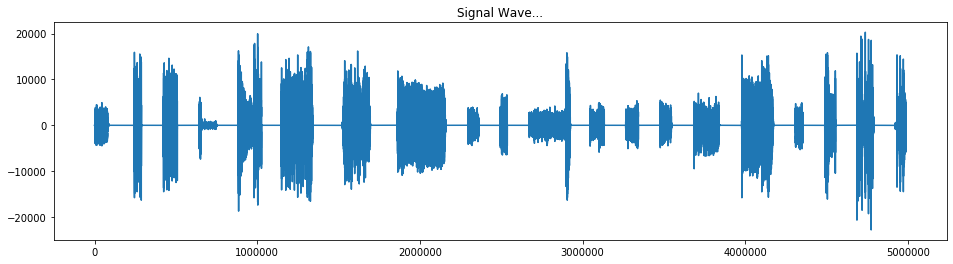

In [4]:
wavname = './biisivisailucovid19.mp3.wav'

spf = wave.open(wavname, "r")
framerate = spf.getframerate()
samplewidth = spf.getsampwidth()
nchannels = spf.getnchannels()
print('Framerate: ', framerate)
print('Samplewidth: ', samplewidth)
print('NChannels: ', nchannels)

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "Int16")


# If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)

plt.figure(figsize=(fig_width, fig_height))
#plt.figure(1)
plt.title("Signal Wave...")
plt.plot(signal)
plt.show()

# Split to segments

Length of splitted list 708066


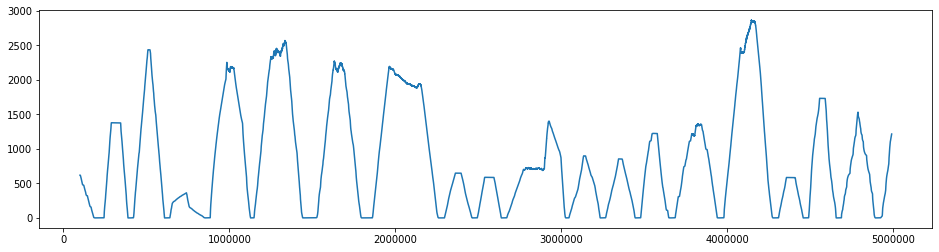

In [5]:
# Splitting
window_size = 100000
# Find quiet moments using zeros and moving average filtering
sig_pd = pd.Series(signal)
smoothed = sig_pd.abs().rolling(window_size).mean()
#, win_type = 'triang'
plt.figure(figsize=(fig_width, fig_height))
plt.plot(smoothed)

# Splitting
splitted = np.split(signal, np.where(smoothed < 1)[0])

print('Length of splitted list', len(splitted))

In [6]:
# Removing dummy items
splitted_clean = [ev for ev in splitted if len(ev) > 7000]

print('Length of splitted list', len(splitted))
print('Length of cleaned list', len(splitted_clean))

Length of splitted list 708066
Length of cleaned list 20


# Saving split songs to wav-files

In [7]:
# Saving as wav
count = 0
for i in splitted_clean:
    count += 1
    if count < 10:
        filename = ''.join(['./songs/Song', '0', str(count), '.wav']) 
    else:
        filename = ''.join(['./songs/Song', str(count), '.wav']) 
    #spf = wave.open(wavname, "r")
    print(filename)
    # Opening file
    wavfile = wave.open(filename, mode = 'wb')
    
    # Set the number of channels.
    wavfile.setnchannels(nchannels)
    
    # Set the sample width to n bytes.
    wavfile.setsampwidth(samplewidth)
    
    # Set the frame rate to n.
    wavfile.setframerate(framerate)
    
    # Write file
    wavfile.writeframes(i)
    wavfile.close()

./songs/Song01.wav
./songs/Song02.wav
./songs/Song03.wav
./songs/Song04.wav
./songs/Song05.wav
./songs/Song06.wav
./songs/Song07.wav
./songs/Song08.wav
./songs/Song09.wav
./songs/Song10.wav
./songs/Song11.wav
./songs/Song12.wav
./songs/Song13.wav
./songs/Song14.wav
./songs/Song15.wav
./songs/Song16.wav
./songs/Song17.wav
./songs/Song18.wav
./songs/Song19.wav
./songs/Song20.wav


# Convert all wavs to mp3

In [8]:
mypath = './songs'
wavfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)) & (f[-4:] == '.wav'))]

for f in wavfiles:
    wavfilename = ''.join(['./songs/', f])
    mp3filename = ''.join(['.', wavfilename[1:-4], '.mp3'])
    print(wavfilename)
    print(mp3filename)
    sound = AudioSegment.from_wav(wavfilename)
    sound.export(mp3filename, format="mp3")

./songs/Song01.wav
./songs/Song01.mp3
./songs/Song02.wav
./songs/Song02.mp3
./songs/Song03.wav
./songs/Song03.mp3
./songs/Song04.wav
./songs/Song04.mp3
./songs/Song05.wav
./songs/Song05.mp3
./songs/Song06.wav
./songs/Song06.mp3
./songs/Song07.wav
./songs/Song07.mp3
./songs/Song08.wav
./songs/Song08.mp3
./songs/Song09.wav
./songs/Song09.mp3
./songs/Song10.wav
./songs/Song10.mp3
./songs/Song11.wav
./songs/Song11.mp3
./songs/Song12.wav
./songs/Song12.mp3
./songs/Song13.wav
./songs/Song13.mp3
./songs/Song14.wav
./songs/Song14.mp3
./songs/Song15.wav
./songs/Song15.mp3
./songs/Song16.wav
./songs/Song16.mp3
./songs/Song17.wav
./songs/Song17.mp3
./songs/Song18.wav
./songs/Song18.mp3
./songs/Song19.wav
./songs/Song19.mp3
./songs/Song20.wav
./songs/Song20.mp3


# Get names from audd

In [9]:
# Getting filelist
mypath = './songs'
songlist = [f for f in listdir(mypath) if (isfile(join(mypath, f)) & (f[-4:] == '.mp3'))]
mypath = './songs/'

# Final answer dataframe
answer = pd.DataFrame(index = songlist,
                      columns=['Biisin numero', 'Bandi', 'Biisi'])

api_token = 'PUT_YOUR_TOKEN_HERE'

count = 0
for song in songlist:
    count += 1
    answer['Biisin numero'][count-1] = count
    songname = ''.join([mypath, song])
    print('Song: ', songname)
    myfiles = {'file': open(songname ,'rb')}
    data = {
        'Content-Type': 'multipart/form-data', 
        'return': 'timecode,apple_music,deezer,spotify',
        'api_token': api_token
    }
            #'url': song,
        #'url': 'https://audd.tech/example1.mp3',
    result = requests.post('https://api.audd.io/', data=data, files = myfiles)
    # Parsing song and title names
    iartist = result.text.find('artist')
    ititle = result.text.find('title')
    ialbum = result.text.find('album')
    artist = result.text[iartist+9:ititle-3]
    title = result.text[ititle+8:ialbum-3]
    answer['Bandi'][count-1] = artist
    answer['Biisi'][count-1] = title
    #print('Artist: ', artist)
    #print('Title: ', title)
print(result.text)
answer.head(50)

Song:  ./songs/Song01.mp3
Song:  ./songs/Song02.mp3
Song:  ./songs/Song03.mp3
Song:  ./songs/Song04.mp3
Song:  ./songs/Song05.mp3
Song:  ./songs/Song06.mp3
Song:  ./songs/Song07.mp3
Song:  ./songs/Song08.mp3
Song:  ./songs/Song09.mp3
Song:  ./songs/Song10.mp3
Song:  ./songs/Song11.mp3
Song:  ./songs/Song12.mp3
Song:  ./songs/Song13.mp3
Song:  ./songs/Song14.mp3
Song:  ./songs/Song15.mp3
Song:  ./songs/Song16.mp3
Song:  ./songs/Song17.mp3
Song:  ./songs/Song18.mp3
Song:  ./songs/Song19.mp3
Song:  ./songs/Song20.mp3
{"status":"success","result":null}


,Biisin numero,Bandi,Biisi
Song01.mp3,1,Metallica,OF WOLF AND MAN
Song02.mp3,2,""":""success"",""result"":n","s"":""success"",""result"":n"
Song03.mp3,3,""":""success"",""result"":n","s"":""success"",""result"":n"
Song04.mp3,4,Pantera,Domination (2010 Remaster)
Song05.mp3,5,Dio,Rainbow in the Dark
Song06.mp3,6,Cannibal Corpse,Hammer Smashed Face
Song07.mp3,7,Iron Maiden,Powerslave (1998 Remaster)
Song08.mp3,8,Mötley Crüe,Kickstart My Heart
Song09.mp3,9,The Rolling Stones,"Paint It, Black"
Song10.mp3,10,""":""success"",""result"":n","s"":""success"",""result"":n"


# Writing the final answer to a csv-file

In [10]:
answer.to_csv('./Final_answer_Lassi.csv', index = False)